In [1]:
from sympy import *
import sympy, math
from itertools import *
init_printing()
x, y, z = symbols('x y z')

delta_expr = 2 / (exp(-10*x) + 1) - 1  # smooth approximation to the dirac delta function
plot(delta_expr, (x, -3, 3))
def delta(x):
    exp = sympy.exp if isinstance(x, Expr) else math.exp
    return 2 / (exp(-10*x) + 1) - 1
print(f'delta(-1)={delta(-1)}')
print(f'delta(+1)={delta(1)}')

bool_to_value = {
    True: 1,
    False: -1,
}
get_bool = lambda x: x >= 0
truth_values = list(product([True, False], [True, False]))

def tabulate(table):
    rows = []
    for i, row in enumerate(table):
        tag = 'td' if i != 0 else 'th'
        rows.append(f"<tr>{''.join(f'<{tag}>{value}</{tag}>' for value in row)}</tr>")
    return f"<table>{''.join(rows)}</table>"


def truth_table(f):
    from IPython.display import HTML, display
    import inspect
    nargs = len(inspect.signature(f).parameters)
    if nargs == 1:
        table = [[True, False], [f(bool_to_value[b]) for b in [True, False]]]
    elif nargs == 2:
        table = [['', 'True', 'False']]
        for b_row in [True, False]:
            row = [str(b_row)]
            for b_col in [True, False]:
                row.append(f(bool_to_value[b_row], bool_to_value[b_col]))
            table.append(row)
    display(HTML(tabulate(table)))

truth_table(delta)

delta(-1)=-0.9999092042625951
delta(+1)=0.9999092042625952


True,False
0.9999092042625952,-0.9999092042625951


In [2]:
not_ = lambda x: -x
truth_table(not_)

True,False
-1,1


In [3]:
and_ = lambda x, y: delta(x + y + x * y)
truth_table(and_)

,True,False
True,0.999999999999813,-0.9999092042625951
False,-0.9999092042625951,-0.9999092042625951


In [4]:
or_ = lambda x, y: not_(and_(not_(x), not_(y)))
truth_table(or_)

,True,False
True,0.9999092042625951,0.9999092042625951
False,0.9999092042625951,-0.999999999999813


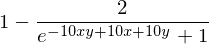

In [5]:
or_(x, y)

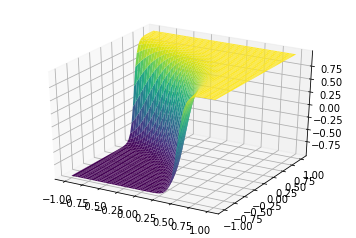

In [6]:
from sympy.plotting import plot3d
plot3d(or_(x, y), (x, -1, 1), (y, -1, 1))

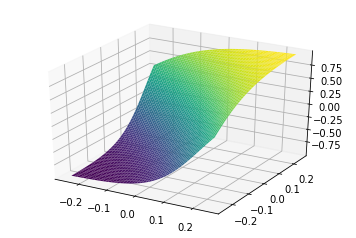

In [7]:
plot3d(or_(x, y), (x, -0.25, 0.25), (y, -0.25, 0.25))

In [48]:
from functools import reduce
from sympy.logic.utilities.dimacs import load as sympy_load_dimacs
        
def load_dimacs(s):
    """Loads a boolean expression from a string.
    
    Based off sympy.logic.utilities.dimacs
    https://github.com/sympy/sympy/blob/57fcd5a941d7c47106bd63fd7b3d79ac032b636b/sympy/logic/utilities/dimacs.py
    """
    import re

    And = lambda *args: reduce(and_, args)
    Or = lambda *args: reduce(or_, args)
    clauses = []

    lines = s.split('\n')

    pComment = re.compile(r'c.*')
    pStats = re.compile(r'p\s*cnf\s*(\d*)\s*(\d*)')

    while len(lines) > 0:
        line = lines.pop(0)

        # Only deal with lines that aren't comments
        if not pComment.match(line):
            m = pStats.match(line)

            if not m:
                nums = line.rstrip('\n').split(' ')
                list = []
                for lit in nums:
                    if lit != '':
                        if int(lit) == 0:
                            continue
                        num = abs(int(lit))
                        sign = True
                        if int(lit) < 0:
                            sign = False

                        if sign:
                            list.append(Symbol("cnf_%s" % num))
                        else:
                            list.append(not_(Symbol("cnf_%s" % num)))

                if len(list) > 0:
                    clauses.append(Or(*list))

    return And(*clauses)

# SAT instance from https://toughsat.appspot.com/ trying to factor 35 using karatsuba multiplication
factor_35_dimacs = '''\
p cnf 6 6 
c Factors encoded in variables 1-3 and 4-6
c Target number: 35
-2 -5 0
1 0
3 0
4 0
6 0
2 5 0
'''
float_circuit = load_dimacs(factor_35_dimacs)
exact_circuit = sympy_load_dimacs(factor_35_dimacs)

possibilities = product(*([[True, False]] * 6))
vars = sorted(exact_circuit.atoms(), key=str)
for possibility in possibilities:
    float_subs = float_circuit.subs({
        var: bool_to_value[val]
        for var, val in zip(vars, possibility)
    }).evalf()
    exact_subs = exact_circuit.subs({
        var: val
        for var, val in zip(vars, possibility)
    })
    assert exact_subs == get_bool(float_subs)
    if exact_subs:
        print(''.join(map(str, map(int, possibility))) + f'={exact_subs}, {get_bool(float_subs)}')

111101=True, True
101111=True, True


Now we've shown we can load a small circuit, and run it using floating point math to arrive at the same solution as sympy's existing logic. Now let's try to factor 35 by gradient descent.

In [49]:
# The circuit is satisfied if its output is close to 1, so create a loss function to do that:
import numpy as np
loss_expr = (float_circuit - 1) ** 2
_loss_function = lambdify(vars, loss_expr, modules='numpy')
loss_function = lambda array: _loss_function(*array)
print(loss_function(np.array([1, 1, 1, 1, -1, 1])))

3.5120876361344667e-26


In [47]:
from scipy.optimize import minimize

res = minimize(loss_function,
               np.zeros(6),
               method='nelder-mead',
               options={'xtol': 1e-30, 'disp': True})
evaluated = float_circuit.subs({var: val for var, val in zip(vars, res.x)}).evalf()
print(f'solution={res.x},\nevaluated={evaluated}\n')
normalized_solution = [np.sign(v) for v in res.x]
normalized_evaluated = float_circuit.subs({var: val for var, val in zip(vars, normalized_solution)}).evalf()
print(f'normalized_solution={normalized_solution},\nevaluated={evaluated}\n')
print(f'loss_function(res.x)={loss_function(res.x)}')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 266
         Function evaluations: 751
solution=[ 0.96007168  1.37241084  0.49484629  0.67831874 -0.70099425  0.13773547],
evaluated=0.999999999999813

normalized_solution=[1.0, 1.0, 1.0, 1.0, -1.0, 1.0],
evaluated=0.999999999999813

loss_function(res.x)=3.495462392556934e-26


In [42]:
float_circuit.subs({var: val for var, val in zip(vars, res.x)}).evalf()

# Putting it all together:

In [63]:
def solve_SAT_with_gradient_descent(dimacs_text):
    float_circuit = load_dimacs(dimacs_text)
    loss_expr = (float_circuit - 1) ** 2
    vars = sorted(float_circuit.free_symbols, key=str)
    print(vars)
    _loss_function = lambdify(vars, loss_expr, modules='numpy')
    loss_function = lambda array: _loss_function(*array)
    res = minimize(
        loss_function,
        np.zeros(len(vars)),
        method='nelder-mead',
        options={'xtol': 1e-30, 'disp': True})
    print(res.x)
    return {var: get_bool(x) for var, x in zip(vars, res.x)}

def check(dimacs_text):
    solution = solve_SAT_with_gradient_descent(dimacs_text)
    print(solution)
    print(f'Does the solution work? Does True=={sympy_load_dimacs(dimacs_text).subs(solution)}?')

    
check(factor_35_dimacs)

[cnf_1, cnf_2, cnf_3, cnf_4, cnf_5, cnf_6]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 266
         Function evaluations: 751
[ 0.96007168  1.37241084  0.49484629  0.67831874 -0.70099425  0.13773547]
{cnf_1: True, cnf_2: True, cnf_3: True, cnf_4: True, cnf_5: False, cnf_6: True}
Does the solution work? Does True==True?


# Something _slightly_ bigger

In [69]:
factor_11_times_13 = '''\
p cnf 8 12 
c Factors encoded in variables 1-4 and 5-8
c Target number: 143
c Factors: 13 x 11
3 2 0
2 6 0
1 0
-3 -2 0
8 0
-2 -7 -6 0
4 0
-3 -2 -6 0
5 0
-2 -6 0
-3 -7 0
3 7 0
'''

In [73]:
%time check(factor_11_times_13)

[cnf_1, cnf_2, cnf_3, cnf_4, cnf_5, cnf_6, cnf_7, cnf_8]
[-0.06463293 -0.04806722  0.01353296  0.10877588 -0.1979872   0.0876021
  0.05516384  0.01156727]
{cnf_1: False, cnf_2: False, cnf_3: True, cnf_4: True, cnf_5: False, cnf_6: True, cnf_7: True, cnf_8: True}
Does the solution work? Does True==False?
CPU times: user 8min 19s, sys: 2.22 s, total: 8min 22s
Wall time: 8min 23s
